In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,accuracy_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

import warnings 
warnings.filterwarnings('ignore')

In [238]:
train_data = pd.read_csv('data/dataset4.csv')
test_data = pd.read_csv('data/dataset3.csv')


In [141]:
train_data.columns

Index(['permalink', 'name', 'homepage_url', 'category_list',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'first_funding_at',
       'last_funding_at'],
      dtype='object')

In [222]:
selected_columns = ['state_code', 'city', 'founded_at',
                    'first_funding_at', 'last_funding_at',  
                    'funding_rounds', 'funding_total_usd',  
                    'category_list', 'status']

train_data = train_data[selected_columns]
train_data.head()

,state_code,city,founded_at,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,category_list,status
0,16,Mumbai,NaN,2015-01-05,2015-01-05,1,10000000,Media,operating
1,DE,Delaware City,2014-09-04,2014-03-01,2014-10-14,2,700000,Application Platforms|Real Time|Social Network...,operating
2,NaN,NaN,NaN,2014-01-30,2014-01-30,1,3406878,Apps|Games|Mobile,operating
3,22,Beijing,2007-01-01,2008-03-19,2008-03-19,1,2000000,Curated Web,operating
4,IL,Champaign,2010-01-01,2014-07-24,2014-07-24,1,-,Software,operating


In [223]:
# Convert 'first_funding_at' column to datetime and extract year
train_data['first_funding_year'] = train_data.first_funding_at.str.split("-").str[0]
train_data['first_funding_year'] = train_data['first_funding_year'].astype(float)

train_data['funding_total_usd'] = train_data['funding_total_usd'].replace('-', np.nan)


# Drop rows with 'first_funding_year' < 1749
train_data.drop(train_data[train_data['first_funding_year'] < 1749].index, inplace=True)
train_data.drop(train_data[train_data['first_funding_year'] > 2024].index, inplace=True)


# Convert 'founded_at', 'first_funding_at', and 'last_funding_at' columns to datetime
train_data['founded_at'] = pd.to_datetime(train_data['founded_at'], errors='coerce')
train_data['first_funding_at'] = pd.to_datetime(train_data['first_funding_at'])
train_data['last_funding_at'] = pd.to_datetime(train_data['last_funding_at'])

# Fill NaN values in 'founded_at' column with values from 'first_funding_at' column
train_data['founded_at'].fillna(train_data['first_funding_at'], inplace=True)

# Convert datetime values to ordinal, handling NaT values
train_data['founded_at'] = train_data['founded_at'].apply(lambda x: x.toordinal() if not pd.isnull(x) else 0)
train_data['first_funding_at'] = train_data['first_funding_at'].apply(lambda x: x.toordinal() if not pd.isnull(x) else 0)
train_data['last_funding_at'] = train_data['last_funding_at'].apply(lambda x: x.toordinal() if not pd.isnull(x) else 0)




In [224]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
# Initialize KNNImputer for numerical features
numerical_imputer = KNNImputer(n_neighbors=5)

# Initialize SimpleImputer for categorical features (impute with mode)
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Define numerical and categorical columns
numerical_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'funding_total_usd'] 
categorical_columns = ['category_list', 'city', 'state_code']  

# Impute missing values for numerical columns using KNNImputer
train_data[numerical_columns] = numerical_imputer.fit_transform(train_data[numerical_columns])

# Impute missing values for categorical columns using SimpleImputer
train_data[categorical_columns] = categorical_imputer.fit_transform(train_data[categorical_columns])

# Ensure category_list is converted back to string after imputation
train_data['category_list'] = train_data['category_list'].astype(str)

# Convert the category_list column into a list of categories
train_data['category_list'] = train_data['category_list'].str.split('|')

# Select the most repeated category for each company
train_data['category_code'] = train_data['category_list'].apply(lambda x: max(set(x), key=x.count))
train_data['category_code'] = train_data['category_code'].apply(lambda x: x.lower())
train_data.head()

,state_code,city,founded_at,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,category_list,status,first_funding_year,category_code
0,16,Mumbai,735603.0,735603.0,735603.0,1,10000000.0,[Media],operating,2015.0,media
1,DE,Delaware City,735480.0,735293.0,735520.0,2,700000.0,"[Application Platforms, Real Time, Social Netw...",operating,2014.0,application platforms
2,CA,San Francisco,735263.0,735263.0,735263.0,1,3406878.0,"[Apps, Games, Mobile]",operating,2014.0,games
3,22,Beijing,732677.0,733120.0,733120.0,1,2000000.0,[Curated Web],operating,2008.0,curated web
4,IL,Champaign,733773.0,735438.0,735438.0,1,2102094.8,[Software],operating,2014.0,software


In [189]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66365 entries, 0 to 66367
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   state_code          66365 non-null  object 
 1   city                66365 non-null  object 
 2   founded_at          66365 non-null  float64
 3   first_funding_at    66365 non-null  float64
 4   last_funding_at     66365 non-null  float64
 5   funding_rounds      66365 non-null  int64  
 6   funding_total_usd   66365 non-null  float64
 7   category_list       66365 non-null  object 
 8   status              66365 non-null  object 
 9   first_funding_year  66341 non-null  float64
 10  category_code       66365 non-null  object 
dtypes: float64(5), int64(1), object(5)
memory usage: 6.1+ MB


In [225]:
train_data['labels'] = np.where(train_data['status'] == 'acquired', 1, 0)
train_data['funding_total_usd'] = train_data['funding_total_usd'].astype(float)

columns_processed = ['state_code', 'city', 'founded_at',
                     'first_funding_at', 'last_funding_at', 'funding_rounds',
                     'funding_total_usd', 'category_code', 'status',
                     'labels']
train_data = train_data[columns_processed]

In [226]:
from sklearn.preprocessing import OrdinalEncoder

state_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
city_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
category_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
status_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)

train_data['state_code'] = state_encoder.fit_transform(train_data['state_code'].values.reshape(-1, 1))
train_data['city'] = city_encoder.fit_transform(train_data['city'].values.reshape(-1, 1))
train_data['category_code'] = category_encoder.fit_transform(train_data['category_code'].values.reshape(-1, 1))
train_data['status'] = status_encoder.fit_transform(train_data['status'].values.reshape(-1, 1))


train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66365 entries, 0 to 66367
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state_code         66365 non-null  float64
 1   city               66365 non-null  float64
 2   founded_at         66365 non-null  float64
 3   first_funding_at   66365 non-null  float64
 4   last_funding_at    66365 non-null  float64
 5   funding_rounds     66365 non-null  int64  
 6   funding_total_usd  66365 non-null  float64
 7   category_code      66365 non-null  float64
 8   status             66365 non-null  float64
 9   labels             66365 non-null  int32  
dtypes: float64(8), int32(1), int64(1)
memory usage: 5.3 MB


Class distribution:
    Class 0 (No Success): 60816
    Class 1 (Success): 5549


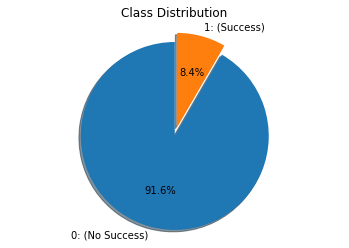

In [227]:
#we are plotting our data distribution to see if data is balanced or not
print(f"""Class distribution:
    Class 0 (No Success): {train_data[train_data['labels']==0].count()[0]}
    Class 1 (Success): {train_data[train_data['labels']==1].count()[0]}""")
labels = "0: (No Success)", "1: (Success)"
total = len(train_data)
no_success= train_data[train_data['labels']==0].count()[0]
success = train_data[train_data['labels']==1].count()[0]
sizes = [no_success/total, success/total]
explode = (0, 0.1)  # only "explode" the 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Class Distribution")
plt.show()

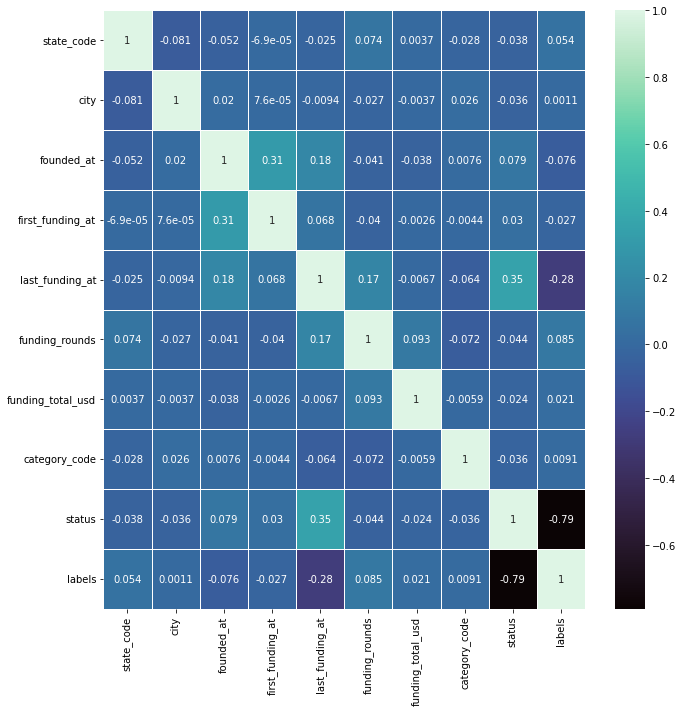

In [196]:
# We plot the heatmap in order to see the corralations between variables
correlation = train_data.corr()

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(correlation, annot=True, linewidths=.5, ax=ax, cmap="mako")

fig.tight_layout()

In [228]:
final_columns =['state_code', 'city', 'founded_at', 'first_funding_at',
                'last_funding_at', 'funding_rounds', 'funding_total_usd', 
                'category_code', 'labels']

train_data = train_data[final_columns]


In [229]:
scaler = StandardScaler()

X = train_data.drop('labels', axis=1)
y = train_data['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123)

# Step 2: Addressing Class Imbalance
class_counts = y_train.value_counts()
class_weight = class_counts[0] / class_counts[1]

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = xgb.XGBClassifier(random_state=123,  scale_pos_weight=class_weight)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
base_accuracy = accuracy_score(y_test, y_pred)
base_accuracy

0.8050930460333007

In [230]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.8050930460333007
Precision: 0.2540956201939151
Recall: 0.6810035842293907
ROC AUC Score: 0.7487439571225097


In [231]:
### FINETUNNING
from sklearn.utils.class_weight import compute_class_weight
scaler = StandardScaler()

X = train_data.drop('labels', axis=1)
y = train_data['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123)

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Addressing Class Imbalance
class_counts = y_train.value_counts()
class_weight = class_counts[0] / class_counts[1]

# Step 3: Hyperparameter Tuning
# Step 3: Hyperparameter Tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 10, 12],
    'subsample': [0.7, 0.8, 0.9],
}

scoring = {'AUC': 'roc_auc', 'recall': 'recall', 'precision': 'precision'}

xgb_model = xgb.XGBClassifier(random_state=123, scale_pos_weight=class_weight, n_estimators=1000)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=scoring, refit='precision', cv=5)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 12, 'subsample': 0.8}


In [232]:
# Step 4: Evaluate Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.901077375122429
Precision: 0.36813922356091033
Recall: 0.246415770609319
ROC AUC Score: 0.6037952012543182


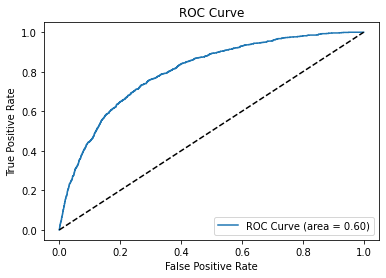

In [233]:
# Step 5: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_xgb.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [234]:
test_data.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [239]:
test_data = test_data[final_columns]
test_data.head()

,state_code,city,founded_at,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,category_code,labels
0,CA,San Diego,1/1/2007,4/1/2009,1/1/2010,3,375000,music,1
1,CA,Los Gatos,1/1/2000,2/14/2005,12/28/2009,4,40100000,enterprise,1
2,CA,San Diego,3/18/2009,3/30/2010,3/30/2010,1,2600000,web,1
3,CA,Cupertino,1/1/2002,2/17/2005,4/25/2007,3,40000000,software,1
4,CA,San Francisco,8/1/2010,8/1/2010,4/1/2012,2,1300000,games_video,0


In [240]:

test_data['state_code'] = state_encoder.transform(test_data['state_code'].values.reshape(-1,1))
test_data['city'] = city_encoder.transform(test_data['city'].values.reshape(-1,1))
test_data['category_code'] = category_encoder.transform(test_data['category_code'].values.reshape(-1,1))



test_data['founded_at'] = pd.to_datetime(test_data['founded_at'])
test_data['first_funding_at'] = pd.to_datetime(test_data['first_funding_at'])
test_data['last_funding_at'] = pd.to_datetime(test_data['last_funding_at'])
test_data['founded_at'] = test_data['founded_at'].apply(lambda x: x.toordinal())
test_data['first_funding_at'] = test_data['first_funding_at'].apply(lambda x: x.toordinal())
test_data['last_funding_at'] = test_data['last_funding_at'].apply(lambda x: x.toordinal())
test_data.head()


,state_code,city,founded_at,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,category_code,labels
0,116.0,3940.0,732677,733498,733773,3,375000,467.0,1
1,116.0,2571.0,730120,731991,733769,4,40100000,-1.0,1
2,116.0,3940.0,733484,733861,733861,1,2600000,-1.0,1
3,116.0,1063.0,730851,731994,732791,3,40000000,664.0,1
4,116.0,3942.0,733985,733985,734594,2,1300000,-1.0,0


In [241]:
test_X = test_data.drop('labels', axis=1)
test_y = test_data['labels']

scaled_test_X = scaler.transform(test_X)

y_pred = best_xgb.predict(scaled_test_X)

accuracy = accuracy_score(test_y, y_pred)
precision = precision_score(test_y, y_pred)
recall = recall_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.733477789815818
Precision: 0.8710359408033826
Recall: 0.6901172529313233
ROC AUC Score: 0.7515003442570727


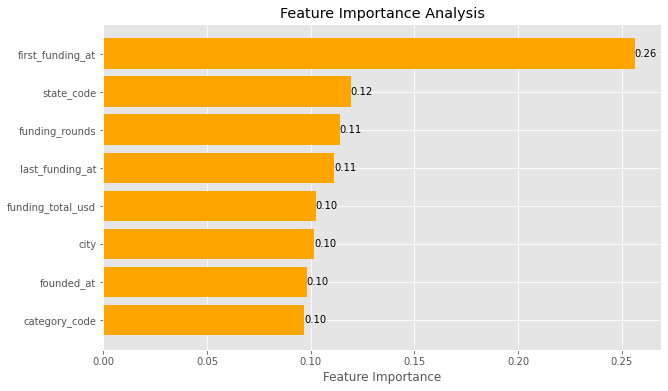

In [253]:
plt.style.use('ggplot')

# Get feature importances from the trained model
importance = best_xgb.feature_importances_

# Get feature names from the training data
feature_names = X_train.columns

# Sort features by importance
sorted_indices = np.argsort(importance)#[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance)), sorted_importance, align='center', color='orange')
plt.yticks(range(len(importance)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')

# Annotate feature importance values on the plot
for i, v in enumerate(sorted_importance):
    plt.text(v, i, f'{v:.2f}', color='black', va='center')


plt.show()

100%|===================| 13272/13273 [61:46<00:00]        

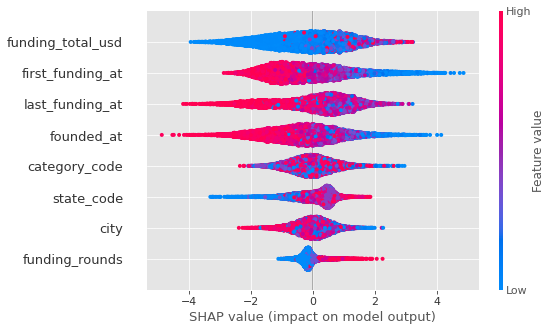

In [256]:
import shap

# Assuming best_xgb is your trained XGBoost model and X_test_scaled is your test data

# Create an explainer object using the trained model and the SHAP TreeExplainer
explainer = shap.TreeExplainer(best_xgb, X_train_scaled)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test_scaled)

# Plot summary plot to visualize feature importance
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

# Display the plot
plt.show()


In [255]:
#store variables and sessisons
import joblib


joblib.dump(best_xgb, 'utils/model.pkl') # save the model
joblib.dump(scaler, 'utils/scaler.pkl') # save scaler
joblib.dump(category_encoder, 'utils/category_encoder.pkl') #save category encoder
joblib.dump(city_encoder, 'utils/city_encoder.pkl')
joblib.dump(state_encoder, 'utils/state_encoder.pkl')


['utils/state_encoder.pkl']